In [1]:
from typing import *
from pathlib import Path
import numpy as np
import matplotlib
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import itertools

import scipy.stats
from statsmodels.stats.multitest import fdrcorrection

from matplotlib.patches import Patch
import matplotlib.transforms as mtransforms
import string

# Make font editable in AI
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Helper code

In [2]:
def compute_pvalues(abund_df: pd.DataFrame):
    df_entries = []
    for (i1, m1), (i2, m2) in itertools.combinations(enumerate(method_order), 2):
        _x = abund_df.loc[abund_df['Method'] == m1, :].sort_values(by=['HeldoutSubjectIdx', 'TaxonIdx'])
        _y = abund_df.loc[abund_df['Method'] == m2, :].sort_values(by=['HeldoutSubjectIdx', 'TaxonIdx'])
        _merged = _x[['HeldoutSubjectIdx', 'TaxonIdx', 'Error']].merge(
            _y[['HeldoutSubjectIdx', 'TaxonIdx', 'Error']],
            on=['HeldoutSubjectIdx', 'TaxonIdx'],
            how='outer',
            suffixes=['_1', '_2']
        )
        _x = _merged['Error_1'].to_numpy()
        _y = _merged['Error_2'].to_numpy()

        _k = (~np.isnan(_x)) & (~np.isnan(_y))
        _x = _x[_k]
        _y = _y[_k]

        if len(_x) == 0 or len(_y) == 0:
            continue
            
        _stat, _pval = scipy.stats.wilcoxon(_x, _y, alternative='two-sided')
        df_entries.append({
            'Method A': m1,
            'Method B': m2,
            'p': _pval,
            'WilcoxonStatistic': _stat
        })
    pval_df = pd.DataFrame(df_entries)
    
    # FDR correction.
    _, bh_pvals = fdrcorrection(pval_df['p'])
    pval_df['BHCorrectedp'] = bh_pvals
    return pval_df

def annot_pvalue(ax, pvalue, x1, x2, y, h, color='black', log_scale=False, text_label=None, fontsize: int = 5):
    # statistical annotation
    grid_x = np.array([x1, x1, x2, x2])
    grid_y = np.array([0.5*h, 1.5*h, 1.5*h, 0.5*h])
    if log_scale:
        grid_y = np.exp(np.log10(y) + grid_y)
    else:
        grid_y = y + grid_y
    ax.plot(grid_x, grid_y, lw=0.7, c=color)

    if text_label is not None:
        text_x = 0.5 * (x1 + x2)
        # text_y = grid_y[0]
        if log_scale:
            text_y = np.exp(np.log10(y) + 1.5 * h)
        else:
            text_y = y + 0.8 * h
        t = ax.text(
            text_x, text_y, text_label, ha='center', va='bottom', color=color, size=fontsize
        )


def make_boxplot(
    ax,
    df: pd.DataFrame,
    method_order: List[str],
    method_labels: Dict[str, str],
    method_colors: Dict[str, np.ndarray],
    lb: float,
    xlabel: Optional[str] = None,
    ylabel: Optional[str] = None,
    eps: float = 0.0,
    box_width: float = None,
):
    def agg_fn(_df):
        _df = _df.loc[(_df['Truth'] > lb) & (_df['TimePoint'] != 0)]
        truth = _df['Truth'].to_numpy() + eps
        pred = _df['Pred'].to_numpy() + eps

        err = np.sqrt(np.mean(np.square(
            np.log10(pred) - np.log10(truth)
        )))  # Root mean squared?
        
        return pd.Series({'Error': err}, index=['Error'])

    df = df.loc[df['Truth'] > lb, :]
    df = df.groupby(['Method', 'HeldoutSubjectIdx', 'TaxonIdx']).apply(agg_fn).reset_index()
    df = df.loc[
        df['Method'].isin(method_order)
    ].sort_values(
        by='Method',
        key=lambda col: col.map({m: i for i, m in enumerate(method_order)})
    )

    sns.boxplot(
        data=df,
        ax=ax,
        x='Method',
        y='Error',
        showfliers=False,
        palette=method_colors,
        whis=(2.5, 97.5),
        width=box_width,
        boxprops=dict(edgecolor='black', linewidth=1),         # Box outline
        medianprops=dict(color='black', linewidth=1),           # Median line
        whiskerprops=dict(color='black', linewidth=1),  # Whiskers
        capprops=dict(color='black', linewidth=1)            # Caps
    )
    # sns.stripplot(
    #     data=df,
    #     ax=ax,
    #     x='Method',
    #     y='Error',
    #     color='white', edgecolor='black', linewidth=1.0
    # )

    labels = [
        method_labels[item.get_text()]
        for item in ax.get_xticklabels()
    ]
    ax.set_xticklabels(labels, rotation=45, ha='right')

    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)

    ax.set_axisbelow(True)
    ax.yaxis.grid(True, 'major', linewidth=1, color='#e6e6e6')

    # ============= Compute and Render PValues.
    pvalue_df = compute_pvalues(df)
    # display(pvalue_df)
    method_indices = {m: i for i, m in enumerate(method_order)}

    j = 0
    for idx, row in pvalue_df.iterrows():
        # only show non-sig
        if row['BHCorrectedp'] > 0.05:
            c = 'black'
            lbl = 'n.s.'
        else:
            continue

        method1 = row['Method A']
        method2 = row['Method B']
        x1 = method_indices[method1]
        x2 = method_indices[method2]
        # y_annot = df['Error'].max()
        y_annot = np.quantile(df['Error'], q=0.975)
        annot_pvalue(ax, row['BHCorrectedp'], x1=x1, x2=x2, y=y_annot + 0.5 + 0.5 * (j), h=0.05, color=c, text_label=lbl, fontsize=10)
        j += 1 
    return df, pvalue_df

# Load data

In [3]:
base_dir = Path()
healthy_rel_df = pd.concat([
    pd.read_csv(base_dir / "mdsine2-modules" / "relative_cv.tsv", sep='\t').assign(Method="MDSINE2"),
    pd.read_csv(base_dir / "mdsine2-nomodules" / "relative_cv.tsv", sep='\t').assign(Method="MDSINE2 (No Modules)"),
    pd.read_csv(base_dir / "mdsine2-noqpcr-modules" / "relative_cv.tsv", sep='\t').assign(Method="RA-MDSINE2"),
    pd.read_csv(base_dir / "mdsine2-noqpcr-nomodules" / "relative_cv.tsv", sep='\t').assign(Method="RA-MDSINE2 (No Modules)"),
    pd.read_csv(base_dir / "regression_clv_elastic_net" / "relative_cv.tsv", sep='\t').assign(Method="cLV"),
    pd.read_csv(base_dir / "regression_glv-ra_ridge" / "relative_cv.tsv", sep='\t').assign(Method="gLV-RA (ridge)"),
    pd.read_csv(base_dir / "regression_glv-ra_elastic_net" / "relative_cv.tsv", sep='\t').assign(Method="gLV-RA (elastic net)"),
    pd.read_csv(base_dir / "regression_glv_ridge" / "relative_cv.tsv", sep='\t').assign(Method="gLV (ridge)"),
    pd.read_csv(base_dir / "regression_glv_elastic_net" / "relative_cv.tsv", sep='\t').assign(Method="gLV (elastic net)"),
    pd.read_csv(base_dir / "mbtransfer" / "log" / "relative_cv.tsv", sep='\t').assign(Method="mbtransfer_log"),
    
])

# Plot colors

In [5]:
method_labels = {
    'MDSINE2': 'MDSINE2', 
    'MDSINE2 (No Modules)': r'MDSINE$2^{-M}$',
    'RA-MDSINE2': 'RO-MDSINE2',
    'RA-MDSINE2 (No Modules)': 'RO-MDSINE$2^{-M}$',
    'cLV': 'cLV', 
    'gLV-RA (ridge)': 'RA-gLV-L2', 
    'gLV-RA (elastic net)': 'RA-gLV-net',
    'gLV (elastic net)': 'gLV-net', 
    'gLV (ridge)': 'gLV-L2', 
    'LRA': 'RA-L',
    'mbtransfer_log': 'mbtransfer  (log)',
}
palette = sns.color_palette("tab10", n_colors=10)
paired_palette = sns.color_palette("Paired")
gradient_palette = sns.color_palette("Greys", n_colors=11)
method_colors = {
    'MDSINE2': palette[0], 
    'MDSINE2 (No Modules)': palette[1], 
    'RA-MDSINE2': paired_palette[0], 
    'RA-MDSINE2 (No Modules)': paired_palette[6], 
    'gLV (ridge)': palette[2],
    'gLV (elastic net)': palette[3],
    'gLV-RA (elastic net)': paired_palette[4], 
    'gLV-RA (ridge)': paired_palette[2],
    'cLV': palette[4],
    'LRA': palette[5],
    'mbtransfer_log': gradient_palette[2],
}

# Plots

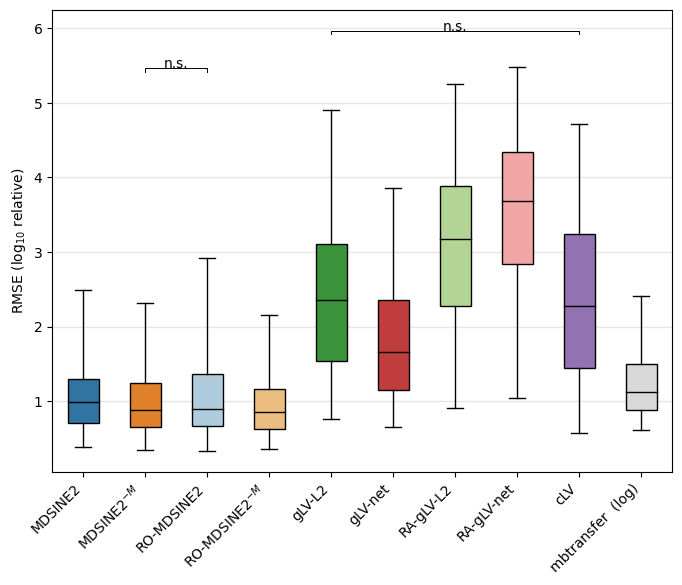

In [6]:
method_order = ['MDSINE2', 'MDSINE2 (No Modules)', 'RA-MDSINE2', 'RA-MDSINE2 (No Modules)', 'gLV (ridge)', 'gLV (elastic net)', 'gLV-RA (ridge)', 'gLV-RA (elastic net)', 'cLV', 'LRA', 'mbtransfer_log']


fig, ax = plt.subplots(1, 1, figsize=(8, 6))

box_width = 0.5
# lb = 1e-5
# method_order = ['MDSINE2', 'MDSINE2 (No Modules)', 'gLV (ridge)', 'gLV (elastic net)', 'mbtransfer']
# healthy_abs_errors = make_boxplot(axes['healthy_abs'], healthy_abs_df, method_order, method_labels, method_colors, xlabel='', ylabel=r'RMSE ($\log_{10}$ Concentration)', lb=lb, eps=1e3, box_width=0.5)

lb = 1e-10
healthy_rel_errors = make_boxplot(ax, healthy_rel_df, method_order, method_labels, method_colors, xlabel='', ylabel='RMSE ($\log_{10}$ relative)', lb=lb, eps=1e-8, box_width=box_width)

plt.savefig('mbtransfer_healthy_cohort.pdf',bbox_inches='tight')